### Importing relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
# Ignore all warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth', None)

In [2]:
#NLP libraries 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
import gensim
from gensim import corpora
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordcloud')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading wordcloud: Package 'wordcloud' not found in
[nltk_data]     index
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Reading data 

In [4]:
df = pd.read_csv('BA_reviews.csv')
df.head(5)

,Unnamed: 0,reviews
0,0,✅ Trip Verified | The worst business class ex...
1,1,Not Verified | Quite possibly the worst busin...
2,2,Not Verified | I will never be flying with BA...
3,3,✅ Trip Verified | On the my trip to Mexico Ci...
4,4,✅ Trip Verified | I upgraded at check in to C...


In [5]:
df['reviews'].head(5)

0    ✅ Trip Verified |  The worst business class ex...
1    Not Verified |  Quite possibly the worst busin...
2    Not Verified |  I will never be flying with BA...
3    ✅ Trip Verified |  On the my trip to Mexico Ci...
4    ✅ Trip Verified |  I upgraded at check in to C...
Name: reviews, dtype: object

In [6]:
df.shape

(1000, 2)

In [7]:
df.isnull().sum()

Unnamed: 0    0
reviews       0
dtype: int64

Our data does not have missing values 

### Data cleaning and preprocessing 

In [8]:
def preprocess_text(text):
    # Converting the text to lowercase
    text = text.lower()
    # Removing special characters, emojis, and symbols
    text = text.encode('ascii', 'ignore').decode()
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

In [9]:
df['clean_reviews'] = df['reviews'].apply(preprocess_text)

In [10]:
# Splitting the text into two parts based on the '|' separator
split_reviews = df['clean_reviews'].str.split('|', expand=True)

# Assigning the first part to a new column 'verification_status'
df['verification_status'] = split_reviews[0].str.strip()

# Assigning the second part to a new column 'review_content'
df['review_content'] = split_reviews[1].str.strip()

# Dropping the original 'clean_reviews' column
df.drop(columns=['clean_reviews'], inplace=True)


In [11]:
 
# Sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'


In [12]:
# Appling the sentiment analysis to each review
#df['sentiment'] = df['review_content'].apply(analyze_sentiment)
df['sentiment'] = df['review_content'].apply(get_sentiment)

In [13]:
df.drop(['verification_status', 'reviews', 'Unnamed: 0'], axis=1, inplace=True)

In [14]:
df.tail(10)

,review_content,sentiment
990,london vancouver . check agent helpful searchi...,Positive
991,first class zone heathrow t5 concorde lounge g...,Positive
992,miserable experience first class london chicag...,Negative
993,leeds bradford la vega via heathrow . customer...,Positive
994,dallas london heathrow first class . worst exp...,Negative
995,tenerife heathrow . effectively budget airline...,Positive
996,"heathrow larnaca - departed time , flight near...",Positive
997,los angeles london . enjoyable comfortable fli...,Positive
998,"london phoenix , ba289 yesterday . plane suppo...",Positive
999,san francisco london . paying 4000 flight canc...,Neutral


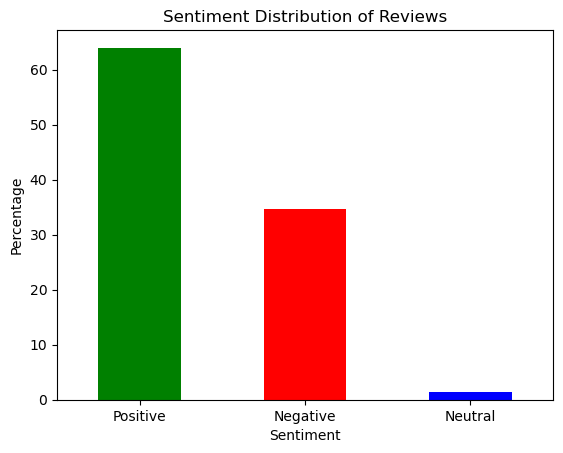

In [15]:
# Visualize the sentiment distribution
sentiment_distribution = df['sentiment'].value_counts(normalize=True) * 100
sentiment_distribution.plot(kind='bar', rot=0, color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.show()

In [16]:
# Generate word clouds for positive and negative reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'Positive']['review_content'])
negative_reviews = ' '.join(df[df['sentiment'] == 'Negative']['review_content'])

# Create word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)



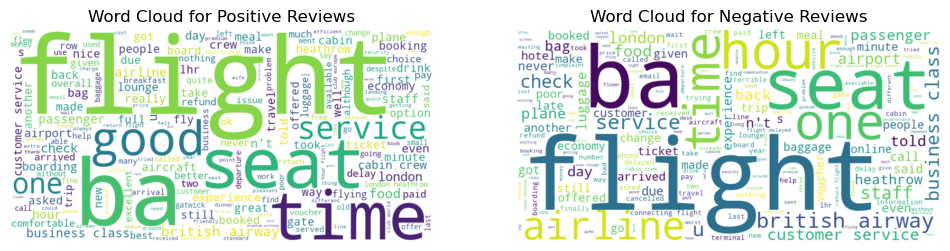

In [17]:
# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')

plt.show()

In [33]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Tokenize the review content
#df['review_content'] = df['review_content'].apply(lambda x: x.split())

# Extract preprocessed data from the 'review_content' column
preprocessed_data = df['review_content'].tolist()

# Create dictionary and bag-of-words corpus
id2word = Dictionary(preprocessed_data)
corpus = [id2word.doc2bow(tokens) for tokens in preprocessed_data]

# Train LDA model with 10 topics
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=5)

# Get topics for each document
topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Output the topics in a more readable format
for i, topic_dist in enumerate(topics):
    print(f"Document {i}:")
    for topic in topic_dist:
        print(f"Topic {topic[0]}: {topic[1]}")
    print()

Document 0:
Topic 2: 0.5919291973114014
Topic 4: 0.402636855840683

Document 1:
Topic 0: 0.0109688276425004
Topic 3: 0.26665493845939636
Topic 4: 0.7188891768455505

Document 2:
Topic 0: 0.3884933292865753
Topic 2: 0.5699215531349182
Topic 3: 0.0398062989115715

Document 3:
Topic 3: 0.9957320690155029

Document 4:
Topic 3: 0.32114437222480774
Topic 4: 0.6703239679336548

Document 5:
Topic 0: 0.8966920971870422
Topic 4: 0.09523413330316544

Document 6:
Topic 0: 0.49790072441101074
Topic 3: 0.4310939311981201
Topic 4: 0.06719224900007248

Document 7:
Topic 3: 0.9881563186645508

Document 8:
Topic 3: 0.9836006164550781

Document 9:
Topic 0: 0.6821209788322449
Topic 4: 0.30213385820388794

Document 10:
Topic 3: 0.3309554159641266
Topic 4: 0.6623689532279968

Document 11:
Topic 2: 0.2901287078857422
Topic 4: 0.7059354186058044

Document 12:
Topic 3: 0.3085082769393921
Topic 4: 0.6880772113800049

Document 13:
Topic 0: 0.8831067085266113
Topic 4: 0.1125725731253624

Document 14:
Topic 0: 0.5

In [35]:
# Assuming your LDA model object is named 'lda_model'
for idx, topic in lda_model.print_topics():
    print("Topic {}:".format(idx))
    print(topic)
    print()

Topic 0:
0.091*"." + 0.027*"," + 0.022*"flight" + 0.011*"ba" + 0.009*")" + 0.007*"service" + 0.006*"time" + 0.006*"food" + 0.006*"get" + 0.005*"london"

Topic 1:
0.046*"." + 0.031*"," + 0.019*"flight" + 0.006*"ba" + 0.005*"time" + 0.005*"service" + 0.004*"british" + 0.004*")" + 0.004*"hour" + 0.004*"would"

Topic 2:
0.074*"." + 0.041*"flight" + 0.032*"," + 0.011*"ba" + 0.011*"service" + 0.008*"seat" + 0.008*"time" + 0.008*"hour" + 0.007*"london" + 0.005*"crew"

Topic 3:
0.083*"." + 0.060*"," + 0.016*"flight" + 0.011*"ba" + 0.010*"seat" + 0.007*"service" + 0.006*"time" + 0.006*"hour" + 0.006*"london" + 0.005*"one"

Topic 4:
0.095*"." + 0.041*"," + 0.017*"flight" + 0.016*"ba" + 0.009*"seat" + 0.008*"service" + 0.006*"good" + 0.006*"u" + 0.006*"time" + 0.005*"("



In [36]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize the LDA model
lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [38]:
# Get the most significant terms for each topic
topics_terms = lda_model.show_topics(num_topics=5, num_words=10, formatted=False)

# Print the topics
for topic_id, topic_terms in topics_terms:
    print(f"Topic {topic_id + 1}: {' '.join([term[0] for term in topic_terms])}")

Topic 1: . , flight ba ) service time food get london
Topic 2: . , flight ba time service british ) hour would
Topic 3: . flight , ba service seat time hour london crew
Topic 4: . , flight ba seat service time hour london one
Topic 5: . , flight ba seat service good u time (
